## WavCeption V1: just a 1-D Inception approach

나는 단지 내가 가지고 놀던 작은 커널(toy)을 공유하기를 원했고 이는 나에게 **놀라운 결과(amazing results)**를 주었다. 나는 현재 시간이 없었기 때문에 사람들이 어떻게 사용하는지 공유하고 싶다 :-D. **WavCeption V1** network은 일반 convolutional neural network에 비해 인상적인 결과를 생성하는 것으로 보인다, 하지만 이 competition에 WavCeption V1은 pre-processing과 알려지지 않은 트랙 관리(unknown tracks management)에 대한 노력이 이는 것으로 보인다. WavCeption V1은 Google`s incption network와 같은 아이디어를 기반으로 한다.

나는 몇 주 전에 구현한 모듈을 작성하여 이것은 cascade로 여러 모듈들을 연결함으로써 1D-inception network를 쉽게 구축할 수 있도록 구현한 모델을 작성했다.(아래 참조)

불행하고 여러 Kaggle 전략 때문에, 이것은 kernel machine에서는 작동되지 않는다, 그래서 나는 너가 이것을 다운로드하여 이것을 너의 machine에서 작동하기를 권장한다.

모델을 12시간 동안 무리 없이 실행함으로써 리더보드에서 0.76(local test에서 0.84)를 달성했다. 같은 라인의 다른 시도에서는 local test에서 0.89점을 받았기 때문에 알려지지 않은 클립(unknown clips)을 처리하는 방법이 크게 향상한다.

### Load modules and libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import shutil
import glob
import random
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import IPython
from numpy.fft import rfft, irfft
import itertools

from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy as sp
import tensorflow as tf

### Noise generation functions

이 섹션의 코드는 https://github.com/python-acoustics/python-acoustics/blob/master/acoustics/generator.py 에서 차용 및 수정되었습니다.

In [3]:
def ms(x):
    """Mean value of signal `x` squared.
    :param x: Dynamic quantity.
    :returns: Mean squared of `x`.
    """
    return (np.abs(x)**2.0).mean()

def normalize(y, x=None):
    """normalize power in y to a (standard normal) white noise signal.
    Optionally normalize to power in signal `x`.
    #The mean power of a Gaussian with :math:`\\mu=0` and :math:`\\sigma=1` is 1.
    """
    #return y * np.sqrt( (np.abs(x)**2.0).mean() / (np.abs(y)**2.0).mean() )
    if x is not None:
        x = ms(x)
    else:
        x = 1.0
    return y * np.sqrt( x / ms(y) )
    #return y * np.sqrt( 1.0 / (np.abs(y)**2.0).mean() )

def white_noise(N, state=None):
    state = np.random.RandomState() if state is None else state
    return state.randn(N)

def pink_noise(N, state=None):

    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X))+1.) # +1 to avoid divide by zero
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def blue_noise(N, state=None):
    """
    Blue noise. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power increases with 6 dB per octave.
    Power density increases with 3 dB per octave. 
    
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = np.sqrt(np.arange(len(X)))# Filter
    y = (irfft(X*S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def brown_noise(N, state=None):
    """
    Violet noise.
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power decreases with -3 dB per octave.
    Power density decreases with 6 dB per octave. 
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = (np.arange(len(X))+1)# Filter
    y = (irfft(X/S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

def violet_noise(N, state=None):
    """
    Violet noise. Power increases with 6 dB per octave. 
    
    :param N: Amount of samples.
    :param state: State of PRNG.
    :type state: :class:`np.random.RandomState`
    
    Power increases with +9 dB per octave.
    Power density increases with +6 dB per octave. 
    
    """
    state = np.random.RandomState() if state is None else state
    uneven = N%2
    X = state.randn(N//2+1+uneven) + 1j * state.randn(N//2+1+uneven)
    S = (np.arange(len(X)))# Filter
    y = (irfft(X*S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)

## Tensorfolow utilities

텐서플로 공통 작업을 모듈화하는 유틸리티

In [4]:
# TF Utils
def get_tensorflow_configuration(device="0", memory_fraction=1):
    """
    Function for selecting the GPU to use and the amount of memory the process is allowed to use
    :param device: which device should be used (str)
    :param memory_fraction: which proportion of memory must be allocated (float)
    :return: config to be passed to the session (tf object)
    """
    device = str(advice)
    config = tf.ConfigProto()
    config.allow_soft_placement = True
    config.gpu_options.per_process_gpu_memory_fraction = memory_fraction
    config.gpu_options.visible_device_list = device
    return(config)

def start_tensorflow_session(device="0", memory_fraction=1):
    """
    Starts a tensorflow session taking care of what GPU device is going to be used and
    which is the fraction of memory that is going to be pre-allocated.
    :device: string with the device number (str)
    :memory_fraction: fraction of memory that is going to be pre-allocated in the specified
    device (float [0, 1])
    :return: configured tf.Session
    """
    return(tf.Session(config=get_tensorflow_configuration(device=device, memory_fraction=memory_fraction)))

def get_summary_writer(session, logs_path, project_id, version_id):
    """
    For Tensorboard reporting
    :param session: opened tensorflow session (tf.Session)
    :param logs_path: path where tensorboard is looking for logs (str)
    :param project_id: name of the project for reporting purposes (str)
    :param version_id: name of the version for reporting purposes (str)
    :return summary_writer: the tensorboard writer
    """
    path = os.path.join(logs_path,"{}_{}".format(project_id, version_id)) 
    if os.path.exists(path):
        shutil.rmtree(path)
    summary_writer = tf.summary.FileWriter(path, graph_def=session.graph_def)
    return(summary_writer)

## Paths management module
경로를 처리할 모듈

In [5]:
# Common paths
def _norm_path(path):
    """
    Decorator function intended for using it to normalize a the output of a path retrieval function. Useful for
    fixing the slash/backslash windows cases.
    """
    def normalize_path(*args, **kwargs):
        return os.path.normpath(path(*args, **kwargs))
    return normalize_path


def _assure_path_exists(path):
    """
    Decorator function intended for checking the existence of a the output of a path retrieval function. Useful for
    fixing the slash/backslash windows cases.
    """
    def assure_exists(*args, **kwargs):
        p=path(*args, **kwargs)
        assert os.path.exists(p), "the following path does not exist: '{}'".format(p)
        return p
    return assure_exists


def _is_output_path(path):
    """
    Decorator function intended for grouping the functions which are applied over the output of an output path retrieval
    function
    """
    @_norm_path
    @_assure_path_exists
    def check_existence_or_create_it(*args, **kwargs):
        if not os.path.exists(path(*args, **kwargs)):
            "Path does not exist... creating it: {}".format(path(*args, **kwargs))
            os.makedirs(path(*args, **kwargs))
        return path(*args, **kwargs)
    return check_existence_or_create_it


def _is_input_path(path):
    """
    Decorator function intended for grouping the functions which are applied over the output of an input path retrieval
    function
    """
    @_norm_path
    @_assure_path_exists
    def check_existence(*args, **kwargs):
        return path(*args, **kwargs)
    return check_existence

@_is_input_path
def get_train_path():
    path = "train"
    return path

@_is_input_path
def get_test_path():
    path = "test"
    return path

@_is_input_path
def get_train_audio_path():
    path = os.path.join(get_train_path(), "audio")
    return path

@_is_input_path
def get_scoring_audio_path():
    path = os.path.join(get_test_path(), "audio")
    return path

@_is_output_path
def get_submissions_path():
    path = "working/output"
    return path

@_is_output_path
def get_silence_path():
    path = "working/silence"
    return path

## Utilities

공통 범용 유틸리티

In [6]:
# Utilities
flatten = lambda l: [item for sublist in l for item in sublist]

def batching(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

## Data Tools
데이터 핸들링 툴

In [7]:
# Data tools
def read_wav(filepath, pad=True):
    """
    Given the filepath of a wav file, this function reads it, normalizes it and pads
    it to assure it has 16k samples.
    :param filepath: existing filepath of a wav file (str)
    :param pad: is padding required? (bool)
    :returns: the sample and the target variable (tuple of (np.array, str))
    """
    sample_rate, x = wavfile.read(filepath)
    target = os.path.split(os.path.split(filepath)[0])[1]
    assert sample_rate==16000
    if pad:
        return np.pad(x, (0, 16000-len(x)), mode="constant")/32768, target
    else:
        return x/32768, target
    
def get_batcher(list_of_paths, batch_size, label_encoder=None, scoring=False):
    """
    Builds a batch generator given a list of batches
    :param list_of_paths: list of tuples with elements of format (filepath, target) (list)
    :param batch_size: size of the batch (int)
    :param label_encoder: fitted LabelEncoder (sklearn.LabelEncoder|optional)
    :param scoring: should the target be considered? (bool)
    :returns: batch generator
    """
    for filepaths in batching(list_of_paths, batch_size):
        wavs, targets = zip(*list(map(read_wav, filepaths)))
        if scoring:
            yield np.expend_dims(np.row_stack(wavs), 2), np.row_stack(target)
        else:
            yield np.expand_dims(np.row_stack(wavs), 2), np.expand_dims(label_encoder.transform(np.squeeze(targets)),1)

## Architecture building blocks
Inception-1D (a.k.a wavception)은 이 문제를 위해 몇 주 전에 설계한 모듈입니다. 그것은 일반 컨볼루션 신경망의 성능을 상당히 향상시킨다.

In [8]:
class BatchNorm(object):
    def __init__(self, epsilon=1e-5, momentum=0.999, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name
            
    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x,
                                             decay=self.momentum,
                                             updates_collections=None,
                                             epsilon=self.epsilon,
                                             scale=True,
                                             is_training=train,
                                             scope=self.name)
    
def inception_1d(x, is_train, depth, norm_function, activ_function, name):
    """
    Inception 1D module implementation. 
    :param x: input to the current module (4D tensor with channels-last)
    :param is_train: it is intented to be a boolean placeholder for controling the BatchNormalization behavior (0D tensor)
    :param depth: linearly controls the depth of the network (int)
    :param norm_function: normalization class (same format as the BatchNorm class above)
    :param activ_function: tensorflow activation function (e.g. tf.nn.relu) 
    :param name: name of the variable scope (str)
    """
    with tf.variable_scope(name):
        x_norm = norm_function(name="norm_input")(x, train=is_train)
        
        # Branch 1: 64 x conv 1x1
        branch_conv_1_1 = tf.layers.conv1d(inputs=x_norm, filters=16*depth, kernel_size=1,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_1_1")
        branch_conv_1_1 = norm_function(name="norm_conv_1_1")(branch_conv_1_1, train=is_train)
        branch_conv_1_1 = activ_function(branch_conv_1_1, "activation_1_1")
        
        # Branch 2: 128 x conv 3x3
        branch_conv_3_3 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_3_3_1")
        branch_conv_3_3 = norm_function(name="norm_conv_3_3_1")(branch_conv_3_3, train=is_train)
        branch_conv_3_3 = activ_function(branch_conv_3_3, "activation_3_3_1")
        
        branch_conv_3_3 = tf.layers.conv1d(inputs=branch_conv_3_3, filters=32*depth, kernel_size=3, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_3_3_2")
        branch_conv_3_3 = norm_function(name="norm_conv_3_3_2")(branch_conv_3_3, train=is_train)
        branch_conv_3_3 = activ_function(branch_conv_3_3, "activation_3_3_2")
        
        # Branch 3: 128 x conv 5x5 
        branch_conv_5_5 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_5_5_1")
        branch_conv_5_5 = norm_function(name="norm_conv_5_5_1")(branch_conv_5_5, train=is_train)
        branch_conv_5_5 = activ_function(branch_conv_5_5, "activation_5_5_1")

        branch_conv_5_5 = tf.layers.conv1d(inputs=branch_conv_5_5, filters=32*depth, kernel_size=5, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_5_5_2")
        branch_conv_5_5 = norm_function(name="norm_conv_5_5_2")(branch_conv_5_5, train=is_train)
        branch_conv_5_5 = activ_function(branch_conv_5_5, "activation_5_5_2")
        
        # Branch 4: 128 x conv 7x7
        branch_conv_7_7 = tf.layers.conv1d(inputs=x_norm, filters=16, kernel_size=1, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_7_7_1")
        branch_conv_7_7 = norm_function(name="norm_conv_7_7_1")(branch_conv_7_7, train=is_train)
        branch_conv_7_7 = activ_function(branch_conv_7_7, "activation_7_7_1")

        branch_conv_7_7 = tf.layers.conv1d(inputs=branch_conv_7_7, filters=32*depth, kernel_size=5, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           padding="same", name="conv_7_7_2")
        branch_conv_7_7 = norm_function(name="norm_conv_7_7_2")(branch_conv_7_7, train=is_train)
        branch_conv_7_7 = activ_function(branch_conv_7_7, "activation_7_7_2")
        
        # Branch 5: 16 x (max_pool 3x3 + conv 1x1)
        branch_maxpool_3_3 = tf.layers.max_pooling1d(inputs=x_norm, pool_size=3, strides=1, padding="same", name="maxpool_3")
        branch_maxpool_3_3 = norm_function(name="norm_maxpool_3_3")(branch_maxpool_3_3, train=is_train)
        branch_maxpool_3_3 = tf.layers.conv1d(inputs=branch_maxpool_3_3, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_maxpool_3")
        
        # Branch 6: 16 x (max_pool 5x5 + conv 1x1)
        branch_maxpool_5_5 = tf.layers.max_pooling1d(inputs=x_norm, pool_size=5, strides=1, padding="same", name="maxpool_5")
        branch_maxpool_5_5 = norm_function(name="norm_maxpool_5_5")(branch_maxpool_5_5, train=is_train)
        branch_maxpool_5_5 = tf.layers.conv1d(inputs=branch_maxpool_5_5, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_maxpool_5")
        
        # Branch 7: 16 x (avg_pool 3x3 + conv 1x1)
        branch_avgpool_3_3 = tf.layers.average_pooling1d(inputs=x_norm, pool_size=3, strides=1, padding="same", name="avgpool_3")
        branch_avgpool_3_3 = norm_function(name="norm_avgpool_3_3")(branch_avgpool_3_3, train=is_train)
        branch_avgpool_3_3 = tf.layers.conv1d(inputs=branch_avgpool_3_3, filters=16, kernel_size=1,
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_avgpool_3")
        
        # Branch 8: 16 x (avg_pool 5x5 + conv 1x1)
        branch_avgpool_5_5 = tf.layers.average_pooling1d(inputs=x_norm, pool_size=5, strides=1, padding="same", name="avgpool_5")
        branch_avgpool_5_5 = norm_function(name="norm_avgpool_5_5")(branch_avgpool_5_5, train=is_train)
        branch_avgpool_5_5 = tf.layers.conv1d(inputs=branch_avgpool_5_5, filters=16, kernel_size=1, 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              padding="same", name="conv_avgpool_5")
        
        # Concatenate
        output = tf.concat([branch_conv_1_1, branch_conv_3_3, branch_conv_5_5, branch_conv_7_7, branch_maxpool_3_3, 
                           branch_maxpool_5_5, branch_avgpool_3_3, branch_avgpool_5_5], axis=-1)
        return output

## Load and prepare Data

C:\Users\jsm97\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """


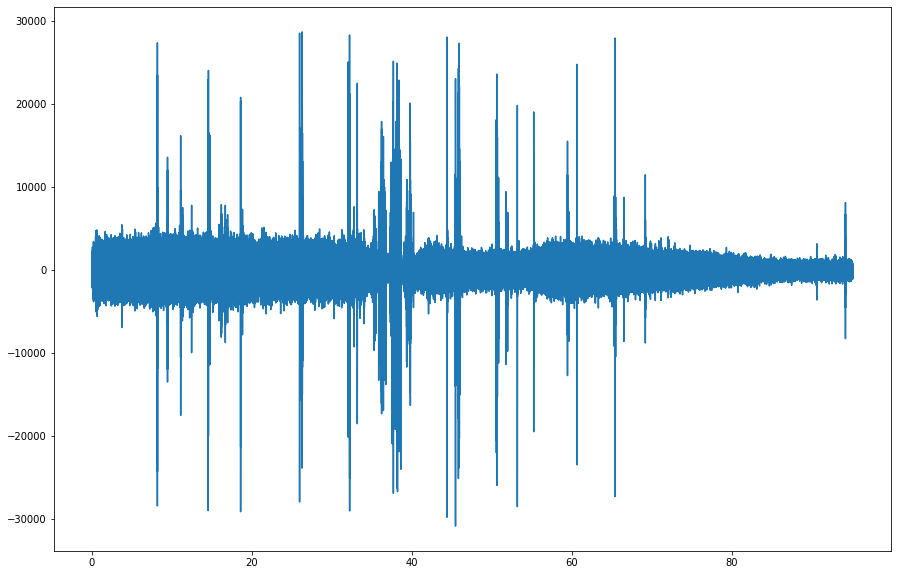

In [9]:
# noise plot
filepaths_noise = glob.glob(os.path.join(get_train_audio_path(), "_background_noise_", "*.wav"))

plt.figure(figsize=(15,10))
sample_rate, data = wavfile.read(filepaths_noise[0])
plt.plot(np.linspace(0., data.shape[0] / sample_rate, data.shape[0]), data)

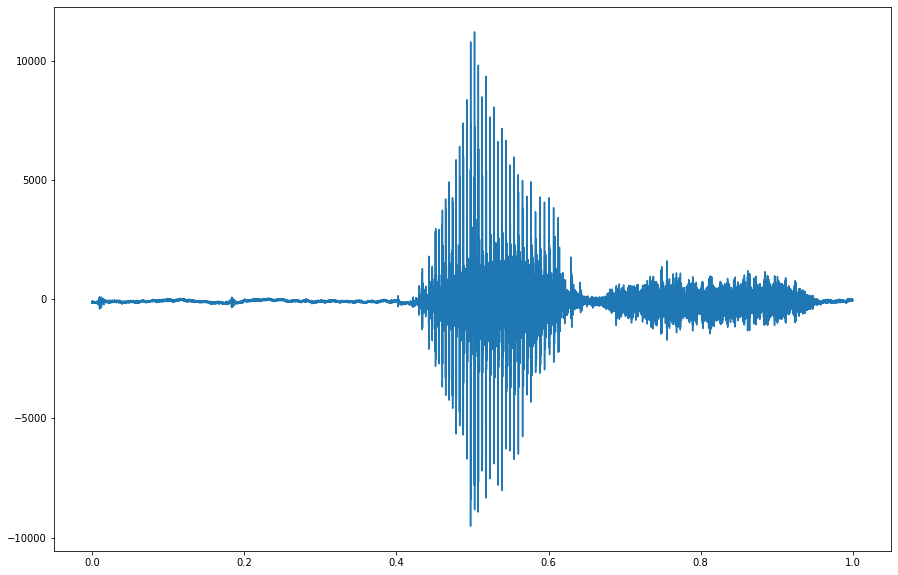

In [10]:
# yes plot
filepaths_yes = glob.glob(os.path.join(get_train_audio_path(), "yes", "*.wav"))

plt.figure(figsize=(15,10))
sample_rate, data = wavfile.read(filepaths_yes[0])
plt.plot(np.linspace(0., data.shape[0] / sample_rate, data.shape[0]), data)
times = np.arange(len(data))/float(sample_rate)

In [11]:
# Synthetic and provided noise addition
filepaths_noise = glob.glob(os.path.join(get_train_audio_path(), "_background_noise_", "*.wav"))

noise = np.concatenate(list(map(lambda x: read_wav(x, False)[0], filepaths_noise)))
noise = np.concatenate([noise, noise[::-1]])
synthetic_noise = np.concatenate([white_noise(N=16000*30, state=np.random.RandomState(655321)), 
                                  blue_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  pink_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  brown_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  violet_noise(N=16000*30, state=np.random.RandomState(655321)),
                                  np.zeros(16000*60)])
synthetic_noise /= np.max(np.abs(synthetic_noise))
synthetic_noise = np.concatenate([synthetic_noise, (synthetic_noise+synthetic_noise[::-1])/2])
all_noise = np.concatenate([noise, synthetic_noise])

C:\Users\jsm97\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
np.random.seed(655321)
random.seed(655321)

path = get_silence_path()

if not os.path.exists(path):
    os.makedirs(path) # It fails in kaggle kernel due to the read-only filesystem

for noise_clip_no in tqdm(range(8000)):
    if noise_clip_no<=4000:
        idx = np.random.randint(0, len(noise)-16000)
        clip = noise[idx:(idx+16000)]
    else:
        idx = np.random.randint(0, len(synthetic_noise)-16000)
        clip = synthetic_noise[idx:(idx+16000)]
    wavfile.write(os.path.join(path, "{0:04d}.wav".format(noise_clip_no)), 16000, 
                               ((32767*clip/np.max(np.abs(clip))).astype(np.int16)))

100%|██████████| 8000/8000 [00:04<00:00, 1682.09it/s]


In [54]:
filepaths = glob.glob(os.path.join(get_train_audio_path(), "**/*.wav"), recursive=True)
filepaths += glob.glob(os.path.join(get_silence_path(), "**/*.wav"), recursive=True)
filepaths = list(filter(lambda fp: "_background_noise_" not in fp, filepaths))

validation_list = open(os.path.join(get_train_path(), "validation_list.txt")).readlines()
test_list = open(os.path.join(get_train_path(), "testing_list.txt")).readlines()
validation_list = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip().replace("/","\\")), validation_list))
testing_list = list(map(lambda fn: os.path.join(get_train_audio_path(), fn.strip().replace("/","\\")), test_list))
training_list = np.setdiff1d(filepaths, validation_list+testing_list).tolist()

In [55]:
random.seed(655321)
random.shuffle(filepaths)
random.shuffle(validation_list)
random.shuffle(testing_list)
random.shuffle(training_list)

In [62]:
# Quick Unit-Tests
# Test number of files and their consistencies
assert all(map(lambda fp: os.path.splitext(fp)[1]==".wav", filepaths))
assert len(filepaths)==64727 - 6 + 8000
assert len(training_list) == len(filepaths) - 6798 - 6835
assert len(validation_list) == 6798
assert len(testing_list) == 6835

# Test file existence
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), validation_list))
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), testing_list))
assert all(map(lambda fn: os.path.exists(os.path.join(fn)), training_list))
assert set(validation_list + testing_list + training_list) == set(filepaths)

# Test non-overlap among sets
assert len(np.intersect1d(validation_list, testing_list))==0
assert len(np.intersect1d(training_list, testing_list))==0
assert len(np.intersect1d(training_list, validation_list))==0

## Architecture building blocks